# Customer Flow Forcast

## Aim
To build an intelligent system which can help Alibaba provide foot-traffic forecasting for those shops which uses Alibaba Point of Sales system.

## Objective
- Based on given foot-traffic for around 2000 stores and basic characteristics of these shops, we need to predict foot-traffic for coming 14 days.
- Current data is log based, we need summarize it on a per day and per shop basis
- Data is sparsely distributed, hence system should be designed to handle this type of data.
- Influence of external factors, like weather, which day of week, holidays, shopping festivals etc needs to be considered while predicting.




In [1]:
import pandas as pd
import numpy as np
import sqlite3
import os.path
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
pd.set_option("display.max_rows",15)
%matplotlib inline

In [2]:
conn = create_engine('sqlite:///../dataset/ijcai_cff_2017.db')

def upload_csv_to_sqlite(file_name, col_names):
    try:
        df = pd.read_sql_query(sql = 'select * from ' + file_name + ' limit 1', con=conn)
        print("Table "+ file_name+" already present")
        return
    except:
        pass
    total_rows = 0
    for df in pd.read_csv('../dataset/'+file_name+'.txt.gz', 
                          compression='gzip', chunksize=5000000, 
                          iterator=True, encoding='utf-8',
                          names=col_names                         
                         ):
        df.to_sql(file_name, conn, if_exists='append',index=False)
        
        total_rows += df.shape[0] 
        print ('For file '+ file_name+' completed {} rows'.format(total_rows))

In [3]:
upload_csv_to_sqlite("shop_info", ("shop_id","city_name",
                                   "location_id", "per_pay",
                                   "score","comment_cnt", "shop_level",
                                   "cate_1_name","cate_2_name","cate_3_name"
                                  ))
upload_csv_to_sqlite("user_view", ("user_id", "shop_id", "time_stamp"))
upload_csv_to_sqlite("user_pay", ("user_id", "shop_id", "time_stamp"))

Table shop_info already present
Table user_view already present
Table user_pay already present


In [4]:
import pickle
def create_sample_pickle(sql_query, pickle_file_name):
    df = pd.read_sql_query(sql=sql_query,con=conn)
    pickle.dump(df, open("../dataset/"+pickle_file_name,"wb"))


## Data Definition

Data is divided into 3 parts,
- **Shop Details**
- **User Visit logs**  
  This data defines physical presence of a user inside a given shop. This doesn't specify for how long was a user present inside the shop, it just logs the entry time.
- **User Purchase logs**  
This data logs the time entry when a payment was made in shop and alibaba payment system was utilized

### Shop Details

In [5]:
pd.read_sql_query("select * from shop_info limit 10", con = conn)

,shop_id,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name
0,1,湖州,885,8,4.0,12.0,2,美食,休闲茶饮,饮品/甜点
1,2,哈尔滨,64,19,NaN,NaN,1,超市便利店,超市,None
2,3,南昌,774,5,3.0,2.0,0,美食,休闲茶饮,奶茶
3,4,天津,380,18,NaN,NaN,1,超市便利店,超市,None
4,5,杭州,263,2,2.0,2.0,0,美食,休闲食品,生鲜水果
5,6,大连,1139,13,3.0,1.0,0,美食,烘焙糕点,面包
6,7,绍兴,145,13,3.0,9.0,2,美食,快餐,西式快餐
7,8,杭州,234,16,3.0,1.0,0,美食,休闲食品,生鲜水果
8,9,杭州,1120,15,4.0,0.0,1,超市便利店,超市,None
9,10,孝感,98,10,NaN,NaN,0,超市便利店,超市,None


### User Visit logs

In [6]:
pd.read_sql_query("select * from user_view limit 10", con = conn)

,user_id,shop_id,time_stamp
0,13201967,1197,2016-10-21 18:00:00
1,19461365,1197,2016-06-28 23:00:00
2,15022321,1197,2016-07-16 19:00:00
3,5440872,1197,2016-07-15 07:00:00
4,12594529,1197,2016-08-07 16:00:00
5,5440872,1197,2016-08-12 08:00:00
6,19918044,1197,2016-09-03 16:00:00
7,9476039,1197,2016-09-04 17:00:00
8,4081995,1197,2016-09-25 10:00:00
9,12594529,1197,2016-08-07 16:00:00


### User Purchase logs

In [7]:
pd.read_sql_query("select * from user_pay limit 10", con = conn)

,user_id,shop_id,time_stamp
0,22127870,1862,2015-12-25 17:00:00
1,3434231,1862,2016-10-05 11:00:00
2,16955285,1862,2016-02-10 15:00:00
3,13799128,1862,2016-01-13 14:00:00
4,13799128,1862,2016-07-05 12:00:00
5,20244878,1862,2016-09-17 15:00:00
6,20244878,1862,2016-05-29 16:00:00
7,438444,1862,2016-02-22 17:00:00
8,22003193,1862,2016-08-07 15:00:00
9,20244878,1862,2016-04-17 16:00:00


In [8]:
query1 = "select max(shop_id), min(shop_id),\
        avg(shop_id) from shop_info";

In [9]:
pd.read_sql_query(query1, conn)

,max(shop_id),min(shop_id),avg(shop_id)
0,2000,1,1000.5


In [10]:
def create_sample_tables(sample_shop_count = 1):
    
    import random
    sample_shop_ids = [random.randint(0, 2001) 
                       for i in range(0,sample_shop_count)]
    #sample_shop_ids
    #from IPython.core.debugger import Tracer; Tracer()() 
    
    conn.execute("drop table sample_user_pay")
    conn.execute("create table sample_user_pay \
AS select * from user_pay where \
shop_id in " + 
            str(sample_shop_ids)
            .replace("[", "(")
            .replace("]",")"))

    conn.execute("drop table sample_user_view")
    conn.execute("create table sample_user_view \
AS select * from user_view where \
shop_id in " + 
            str(sample_shop_ids)
            .replace("[", "(")
            .replace("]",")"))

    conn.execute("drop table sample_shop_info")
    conn.execute("create table sample_shop_info \
AS select * from shop_info where \
shop_id in " + 
            str(sample_shop_ids)
            .replace("[", "(")
            .replace("]",")"))

    pd.read_sql("select count(*) from sample_user_pay", conn)
    pd.read_sql("select count(*) from sample_user_view", conn)

    pd.read_sql("select count(*) from sample_shop_info", conn)

In [11]:
def fill_missing_dates(df):
    df.loc[:,"ts"] = pd.to_datetime(df.ts)
    
    #Re-index to fill missing dates
    date_range = pd.date_range(df.ts.min(), df.ts.max())
    df.set_index(['shop_id', 'ts'], inplace = True, drop = True)
    df =  df.reindex(date_range, level = 1)
    return df

def resample_minute_to_daily_and_combine():    
    #def resample_minute_to_daily_and_combine():
    conn.execute("drop table sample_user_view_grouped")
    conn.execute("create table sample_user_view_grouped AS \
    select shop_id, count(*) as total_view, date(time_stamp) as ts \
    from sample_user_view group by shop_id, \
    date(time_stamp)")
    conn.execute("drop table sample_user_pay_grouped")
    conn.execute("create table sample_user_pay_grouped AS \
    select shop_id, count(*) as total_pay, date(time_stamp) as ts \
    from sample_user_pay group by shop_id, \
    date(time_stamp)")

    df_user_view = pd.read_sql_query("select * from sample_user_view_grouped", con = conn)
    df_user_view = fill_missing_dates(df_user_view)
    df_user_pay = pd.read_sql_query("select * from sample_user_pay_grouped", con = conn)
    df_user_pay = fill_missing_dates(df_user_pay)
    return df_user_view, df_user_pay

In [12]:
def prepare_data(shop_id_count = 1, create = False):   
    if create:
        create_sample_tables(shop_id_count)
    df_user_view, df_user_pay = resample_minute_to_daily_and_combine()
    df_shop_ts = pd.concat([df_user_view, df_user_pay], 
                           axis=1)
    df_shop_ts.reset_index().to_sql("train_data", con = conn, if_exists = 'replace', index = False)
    return df_user_view, df_user_pay, df_shop_ts

In [13]:
def aggregate(shop_id):
    df_shop_ts_filtered = df_shop_ts.loc[(shop_id,"2016-07-01"):,:]

    pay_mean = df_shop_ts_filtered.total_pay.mean()
    view_mean = df_shop_ts_filtered.total_view.mean()

    df_shop_ts_filtered = df_shop_ts_filtered.fillna({"total_view":pay_mean, "total_pay":view_mean})

    df_shop_ts_filtered.loc[shop_id,].plot(subplots = True)

    df_shop_ts_filtered.loc[:,"total_today"] = df_shop_ts_filtered.loc[:,"total_pay"] + df_shop_ts_filtered.loc[:,"total_view"]
    df_shop_ts_filtered = df_shop_ts_filtered.drop(["total_view", "total_pay"], axis = 1)
    print(df_shop_ts_filtered)

    print(df_shop_ts_filtered.total_today.describe())
    return df_shop_ts_filtered

In [14]:
def tsa(shop_id):

    df_shop_ts_filtered_single_shop = aggregate(shop_id).loc[shop_id,:]
    
    
    plt.subplot()
    df_shop_ts_filtered_single_shop.total_today.plot(title = "Daily foot traffic")

    from pandas.tools.plotting import lag_plot
    #lag_plot(df_shop_ts_filtered_single_shop.total_today)

    from pandas.tools.plotting import autocorrelation_plot
    fig, axarr = plt.subplots(2,2,figsize=(17,17))
    autocorrelation_plot(df_shop_ts_filtered_single_shop.total_today, ax = axarr[0,0])

    df_shop_ts_filtered_single_shop.rolling(window=14, center=False).mean().plot()
    df_shop_ts_rolling = df_shop_ts_filtered_single_shop.rolling(window=14, center=False)

    df_shop_ts_rolling.min().plot(fig = fig, ax = axarr[1,1])
    df_shop_ts_rolling.max().plot(fig = fig, ax = axarr[1,0])
    axarr[1,0].set_title('Rolling Min - Period 15 days')
    axarr[1,1].set_title('Rolling Max - Period 15 days')

    #df_shop_ts_rolling.quantile(0.25).plot()
    #df_shop_ts_rolling.quantile(0.5).plot(ax = axarr[0,0])
    #df_shop_ts_rolling.quantile(0.75).plot()
    df_shop_ts_rolling.mean().plot(fig = fig, ax = axarr[0,1])
    axarr[0,1].set_title('Rolling Mean plot - Period 15 days')

    try:
        import statsmodels.api as sm
        df_tsa = df_shop_ts_filtered_single_shop.dropna()
        arma_mod_total_today = sm.tsa.ARMA(df_tsa.total_today, order=(2,2))
        arma_res_total_today = arma_mod_total_today.fit(trend='nc', disp=-1)
        #print(arma_res_total_today.summary())

        fig, ax = plt.subplots() #figsize=(10,8)
        fig = arma_res_total_today.plot_predict(start='2016-08-01',
                                         end='2016-10-30', 
                                         ax=ax,
                                        dynamic=True
                                        )
        legend = ax.legend(loc='upper left')
    except Exception as e:
        print("***********")
        print (e)
        print("***********")

## Grouping foot traffic on daily basis
The "as is" data is an instance based time entry log of user activity, however, our final goal is to predict total expected user activity for a given day. Hence, we will summarize the current data to get total user activity for a given day, on a per shop basis.

In [15]:
df_user_view, df_user_pay, df_shop_ts = prepare_data(2000, False)

### Data grouped based on daily user visit

In [16]:
df_user_view

total_view
shop_id ts                    
1       2016-06-22          10
        2016-06-23          18
        2016-06-24           5
        2016-06-25          22
        2016-06-26          15
        2016-06-27          12
        2016-06-28          12
...                        ...
2000    2016-10-25          14
        2016-10-26          13
        2016-10-27          16
        2016-10-28          12
        2016-10-29          11
        2016-10-30           3
        2016-10-31          15

[150460 rows x 1 columns]

### Data grouped based on User purchases

In [17]:
df_user_pay

total_pay
shop_id ts                   
1       2015-10-10        188
        2015-10-11        272
        2015-10-12        257
        2015-10-13        239
        2015-10-14        277
        2015-10-15        227
        2015-10-16        242
...                       ...
2000    2016-10-25        181
        2016-10-26        184
        2016-10-27        132
        2016-10-28        133
        2016-10-29         67
        2016-10-30         67
        2016-10-31        168

[387133 rows x 1 columns]

## Knowns and Unknowns
Let's brainstorm how to tackle the data

#### Knowns
- Daily total presence of user in a given shop
- Popularity of a given shop
- Category of a given shop
- Koibei.com's score of a given shop
- Publicaly available data - Weather, Public holidays, Day of week, Season ...

#### Unknowns
- Behavior of data
    * We don't know whether data obeys concepts of Seasonality and Stationarity
    * Whether pattern of each shop is statistically comparable or should we design a different system for each given shop.
    * Whether data is linearly separable
    * Correlation / Causation of shop characteristics on the given foot-traffic
    * As this is sparse data, we need to understand how to statistically fill the missing data.
    * Whether given data features are enough for successful prediction or 

## Statistical Learning Approach

### Time Series Analysis

We will be performing TSA on a given store only. Below code picks up a store randomly and plots:
- Foot traffic trend
- Auto-Correlation
- Rolling Statistics
    * Min
    * Max
    * Mean
- ARMA forecast


Sample shop id for TSA: 
772
                    total_today
shop_id ts                     
772     2016-07-01        119.0
        2016-07-02        109.0
        2016-07-03        113.0
        2016-07-04         92.0
        2016-07-05         72.0
        2016-07-06        102.0
        2016-07-07        120.0
...                         ...
2000    2016-10-25        195.0
        2016-10-26        197.0
        2016-10-27        148.0
        2016-10-28        145.0
        2016-10-29         78.0
        2016-10-30         70.0
        2016-10-31        183.0

[242969 rows x 1 columns]
count    242969.000000
mean        194.087600
std         146.074569
min           2.000000
25%         130.000000
50%         170.360212
75%         220.000000
max        5632.924439
Name: total_today, dtype: float64


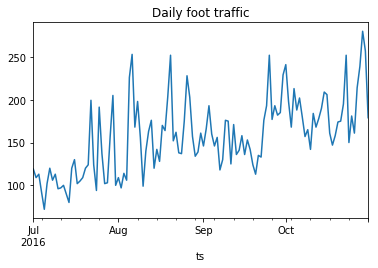

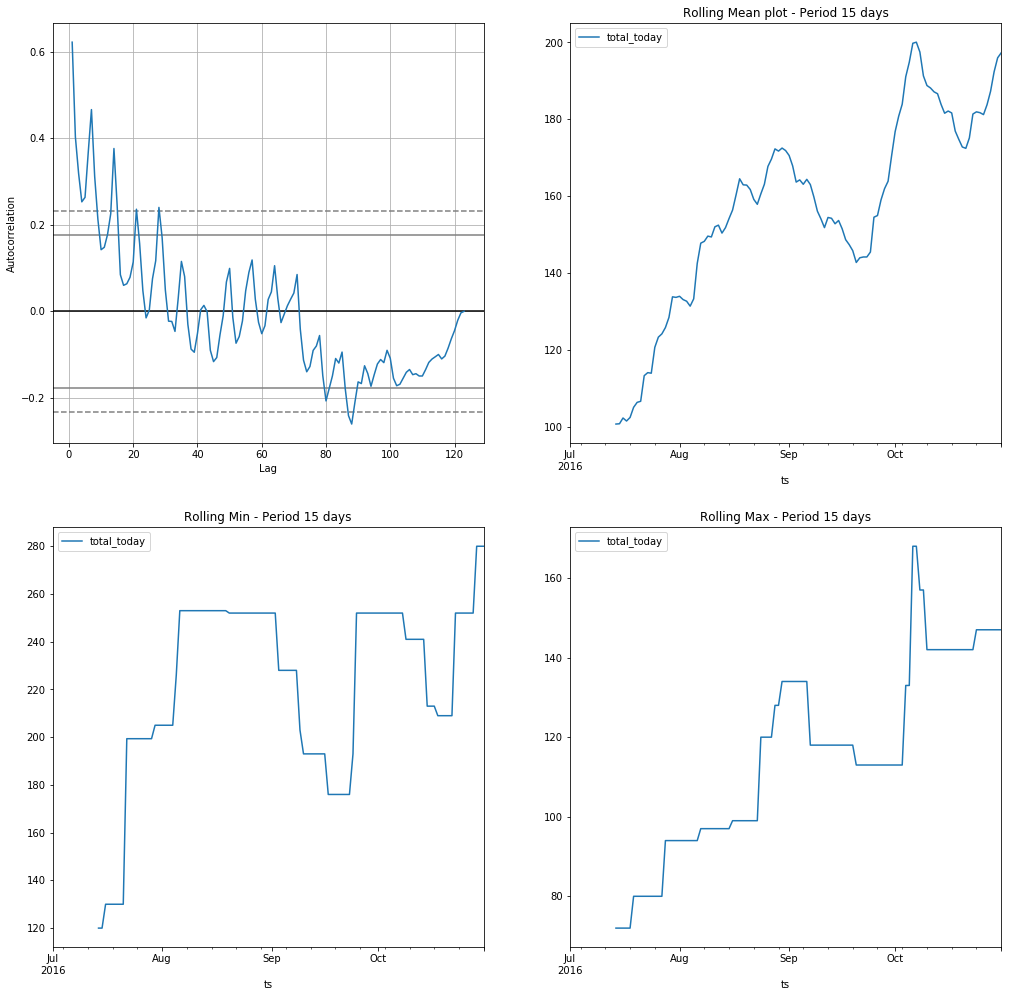

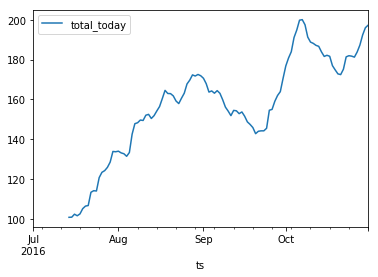

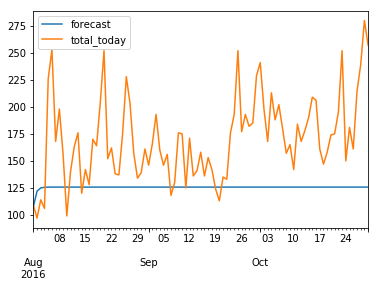

In [22]:
shop_index = df_shop_ts.index.levels[0].get_values()
i = np.random.randint(low = 0, high = len(shop_index), size = 1) #shop_index.get_values()
shop_id = shop_index[i][0]
print("Sample shop id for TSA: " )
print(shop_id)

tsa(shop_id)

Sample shop id for TSA: 
932
                    total_today
shop_id ts                     
932     2016-07-01         66.0
        2016-07-02         48.0
        2016-07-03         51.0
        2016-07-04         57.0
        2016-07-05         52.0
        2016-07-06         67.0
        2016-07-07         54.0
...                         ...
2000    2016-10-25        195.0
        2016-10-26        197.0
        2016-10-27        148.0
        2016-10-28        145.0
        2016-10-29         78.0
        2016-10-30         70.0
        2016-10-31        183.0

[212048 rows x 1 columns]
count    212048.000000
mean        194.143822
std         150.360848
min           2.000000
25%         129.324071
50%         170.324071
75%         218.324071
max        5633.292684
Name: total_today, dtype: float64


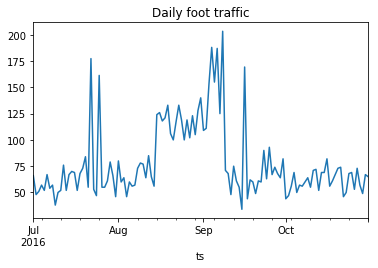

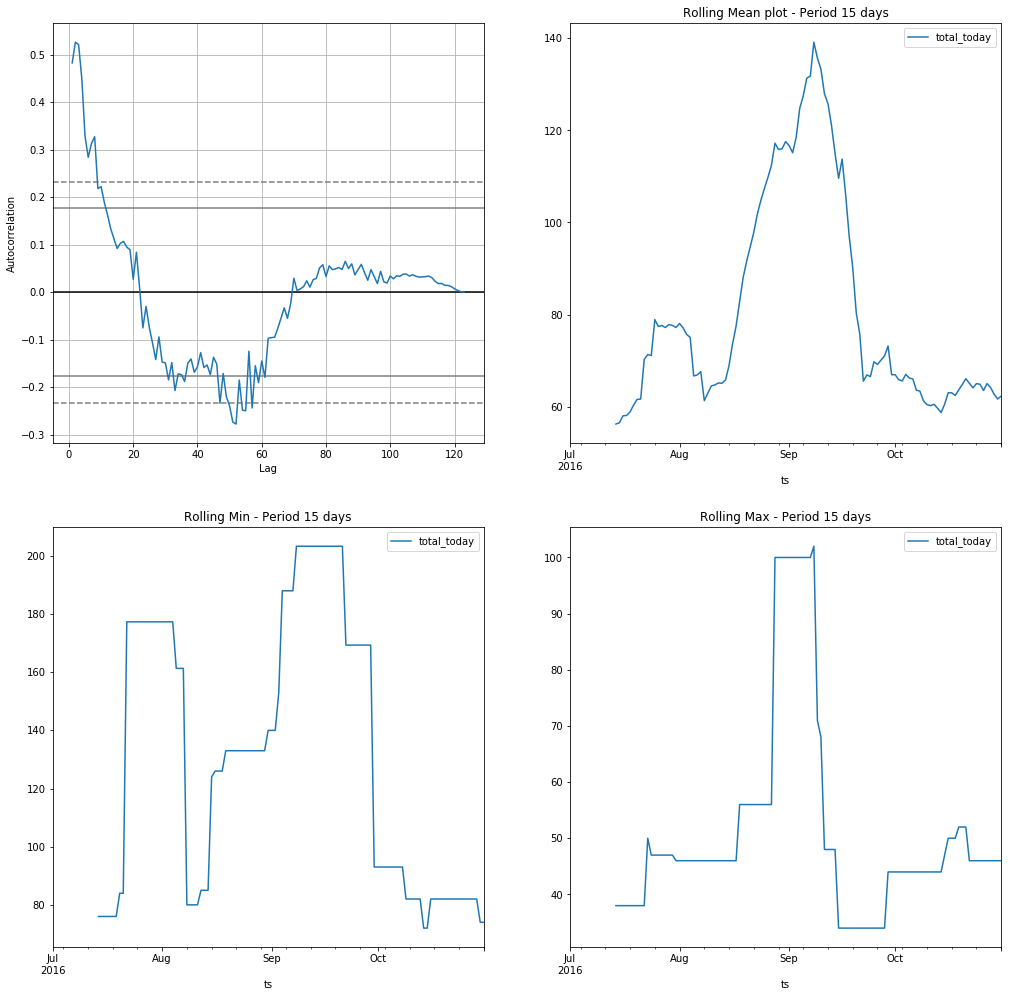

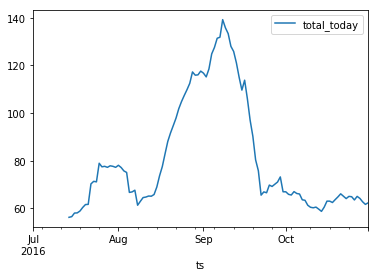

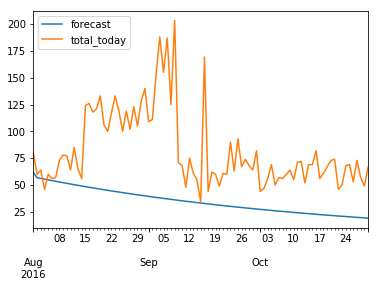

In [20]:
shop_index = df_shop_ts.index.levels[0].get_values()
i = np.random.randint(low = 0, high = len(shop_index), size = 1) #shop_index.get_values()
shop_id = shop_index[i][0]
print("Sample shop id for TSA: " )
print(shop_id)

tsa(shop_id)